In [1]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from Utils.Optuna import optuna_hyperparameter_tuning
import numpy as np
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error
import optuna
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_percentage_error
import pandas as pd
from catboost import CatBoostRegressor
import numpy as np
from pipeline import Pipeline

2024-03-20 04:04:25.526 | INFO     | preprocessing.abstract_prep:<module>:6 - Successfully imported file
2024-03-20 04:04:25.526 | INFO     | preprocessing.check_nans:<module>:7 - Successfully imported file
2024-03-20 04:04:25.533 | INFO     | preprocessing.minmax_scaler:<module>:8 - Successfully imported 'MinMaxScaler' file
2024-03-20 04:04:25.919 | INFO     | preprocessing.check_and_remove_outliers:<module>:6 - Successfully imported 'CheckAndRemoveOutliers' file


In [2]:
data = pd.read_csv("Data/cleaned_data.csv")
columns = pd.read_json("Data/selected_features_15.json")[0]

In [4]:
pipeline = Pipeline(data, CatBoostRegressor)
data_preprocessed = pipeline.data_preprocessing(data)
X = data_preprocessed[columns]
y = data_preprocessed['CREDIT_SCORE']
X.shape

2024-03-20 04:04:53.727 | INFO     | pipeline:data_preprocessing:19 - Data Preprocessing
2024-03-20 04:04:53.728 | INFO     | preprocessing.check_nans:transform:15 - CheckNans is starting
2024-03-20 04:04:53.732 | INFO     | preprocessing.check_nans:transform:18 - No NaNs in dataframe


(826, 85) after nan checking


2024-03-20 04:04:53.927 | INFO     | preprocessing.check_and_remove_outliers:transform:33 - Number of outliers in dataframe: 23
2024-03-20 04:04:53.931 | ERROR    | preprocessing.minmax_scaler:transform:42 - _MinMaxScaler preprocessing class_ is not fitted yet. Please call 'fit' with training data before transforming.
2024-03-20 04:04:53.934 | INFO     | preprocessing.minmax_scaler:transform:53 - _MinMaxScaler preprocessing class_ is starting transformation
2024-03-20 04:04:53.936 | INFO     | preprocessing.minmax_scaler:transform:56 - _MinMaxScaler preprocessing class_ transformation ended
2024-03-20 04:04:53.936 | INFO     | pipeline:data_preprocessing:28 - Data Preprocessing completed


(803, 85) after outliers removal
(803, 85) after scaling


(803, 37)

In [5]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_eval, y_train, y_eval = train_test_split(X_train, y_train, test_size=0.1, random_state=42)
X_train.shape, y_train.shape, X_valid.shape, y_valid.shape, X_eval.shape, y_eval.shape

((577, 37), (577,), (161, 37), (161,), (65, 37), (65,))

<Axes: xlabel='CREDIT_SCORE', ylabel='Count'>

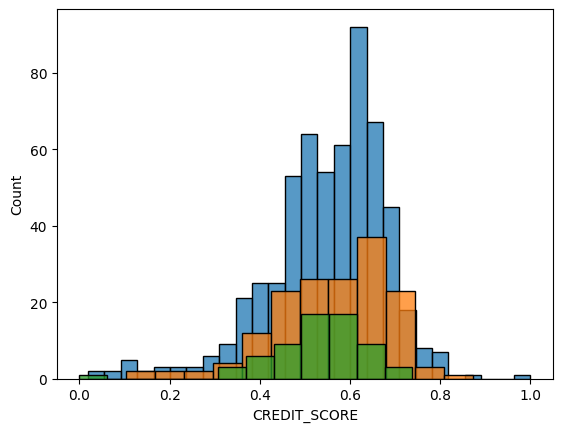

In [6]:
import seaborn as sns
sns.histplot(y_train)
sns.histplot(y_valid)
sns.histplot(y_eval)

In [14]:
# def objective(trial):
#     param = {}
#     param['learning_rate'] = trial.suggest_loguniform("learning_rate", 0.001, 1)
#     param['depth'] = trial.suggest_int('depth', 3, 15)
#     param['l2_leaf_reg'] = trial.suggest_loguniform('l2_leaf_reg', 0.01, 10)
#     param['min_child_samples'] = trial.suggest_int('min_child_samples', 1, 50)
#     param['grow_policy'] = 'Depthwise'
#     param['iterations'] = trial.suggest_int('iterations', 100, 2000)
#     param['use_best_model'] = True
#     param['eval_metric'] = 'RMSE'
#     param['od_type'] = 'iter'
#     param['od_wait'] = 20
#     param['logging_level'] = 'Silent'
    
#     regressor = CatBoostRegressor(**param)

#     regressor.fit(X_train.copy(), y_train.copy(),
#                   eval_set=[(X_eval.copy(), y_eval.copy())],
#                   early_stopping_rounds=10)
#     loss = mean_squared_error(y_valid, regressor.predict(X_valid.copy()))
#     return loss


In [15]:
# {
#     'learning_rate': 0.6063757568124354,
#     'depth': 6,
#     'l2_leaf_reg': 7.17402991755073,
#     'min_child_samples': 32,
#     'iterationsc': 835
# }

In [32]:
import optuna
from catboost import CatBoostRegressor, Pool
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

def objective(trial):
    params = {
        'learning_rate': trial.suggest_loguniform("learning_rate", 0.001, 1),
        'depth': trial.suggest_int('depth', 3, 15),
        'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 0.01, 10),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 50),
        'grow_policy': 'Depthwise',
        'iterations': trial.suggest_int('iterations', 100, 2000),
        'use_best_model': True,
        'eval_metric': 'RMSE',
        'od_type': 'iter',
        'od_wait': 20,
        'logging_level': 'Silent'
    }
    
    regressor = CatBoostRegressor(**params)
    
    regressor.fit(
        X_train, y_train,
        eval_set=[(X_eval, y_eval)],
        early_stopping_rounds=10,
        verbose=False
    )
    
    y_pred = regressor.predict(X_valid)
    loss = mean_squared_error(y_valid, y_pred)
    
    return loss

study = optuna.create_study(study_name='catboost_optimization', direction='minimize')
study.optimize(objective, n_trials=100, n_jobs=-1)

print("Best trial:")
best_trial = study.best_trial
print("  Value: {}".format(best_trial.value))
print("  Params: ")
for key, value in best_trial.params.items():
    print("    {}: {}".format(key, value))


[I 2024-03-20 04:31:16,251] A new study created in memory with name: catboost_optimization
C:\Users\user\AppData\Local\Temp\ipykernel_7944\3334290357.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform("learning_rate", 0.001, 1),
C:\Users\user\AppData\Local\Temp\ipykernel_7944\3334290357.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 0.01, 10),
[I 2024-03-20 04:31:18,161] Trial 3 finished with value: 0.004307826305474203 and parameters: {'learning_rate': 0.2327005189974935, 'depth': 15, 'l2_leaf_reg': 0.10721077896463026, 'min_child_samples': 26, 'iterations': 736}. Be

Best trial:
  Value: 0.0036572786304858397
  Params: 
    learning_rate: 0.014432646508121368
    depth: 4
    l2_leaf_reg: 0.38456207442342455
    min_child_samples: 19
    iterations: 1823


In [34]:
# %%time
# study = optuna.create_study(study_name=f'catboost-seed{42}')
# study.optimize(objective, n_trials=5000, n_jobs=-1, timeout=2400)

In [19]:
study.best_value

0.0035875229947917625

In [20]:
study.best_params


{'learning_rate': 0.015961239950863553,
 'depth': 13,
 'l2_leaf_reg': 1.5709964177093692,
 'min_child_samples': 47,
 'iterations': 1702}

In [ ]:
# {
#     'learning_rate': 0.6063757568124354,
#     'depth': 6,
#     'l2_leaf_reg': 7.17402991755073,
#     'min_child_samples': 32,
#     'iterations': 835
# }
# Training set metrics:
# 0.0020861356718066227
# 0.8788832890998062
# 0.03443580505288086
# 0.04567423422244343
# Validation set metrics:
# 0.0035043265612778513
# 0.7912041150041146
# 0.041729216269541645
# 0.05919735265430247
# 993.3872607256602
# predicted = MinMaxScaling().inverse_transform(pred_valid)
# actual = MinMaxScaling().inverse_transform(y_valid)
# print(mean_squared_error(actual, predicted))
# print(r2_score(actual, predicted))
# print(mean_absolute_error(actual, predicted))
# print(np.sqrt(mean_squared_error(actual, predicted)))
# 0.7804104782312765
# 22.93352241907153
# 31.51804658803683

In [35]:
%%time
optimized_regressor = CatBoostRegressor(learning_rate=0.015961239950863553,
                                        depth=13,
                                        l2_leaf_reg=1.5709964177093692,
                                        min_child_samples=47,
                                        grow_policy='Depthwise',
                                        iterations=1702,
                                        use_best_model=True,
                                        eval_metric='RMSE',
                                        od_type='iter',
                                        od_wait=20,
                                        random_state=42,
                                        logging_level='Silent',
                                        task_type='GPU')
optimized_regressor.fit(X_train.copy(), y_train.copy(),
                        eval_set=[(X_eval.copy(), y_eval.copy())],
                        plot=True,
                        early_stopping_rounds=10)
pred_train = optimized_regressor.predict(X_train.copy())
pred_valid = optimized_regressor.predict(X_valid.copy())

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

CPU times: total: 5.66 s
Wall time: 5.86 s


In [36]:
optimized_regressor.tree_count_

255

In [37]:
optimized_regressor.get_best_iteration()

254

Feature Importances:
[2.46141056e+00 1.68021811e-01 1.36093606e-01 1.80408468e-01
 1.99341802e+00 6.66824780e-01 4.70034897e-01 8.46317114e-01
 4.58939868e-02 1.92272164e-01 5.43008513e+01 8.18543253e-01
 8.02996349e-01 4.27473729e-01 1.09125641e+00 8.42072924e-01
 3.31363073e+00 1.25961992e+00 1.24141840e+00 7.20945399e-01
 1.12552705e+00 6.15736626e-01 9.80717487e+00 7.37534226e-01
 7.83214412e-01 8.17187566e-01 7.67371286e-01 1.55387226e-01
 1.56904338e-01 3.16075644e-02 5.04831622e+00 1.43281981e+00
 2.08811942e+00 3.38602912e-02 8.27338325e-01 3.05039804e+00
 5.41998963e-01]


In [47]:
feature_index = range(1,30)  

pool = Pool(X_train, label=y_train)

feature_statistics = best_regressor.calc_feature_statistics(
    data=pool,
    feature=feature_index,
    plot=True 
)

In [74]:
# tree_structure = best_regressor.get_feature_importance(type='FeatureImportance')
# print("Tree Structure:")
# print(tree_structure)
# features = range(X_train.shape[1])  

# plt.figure(figsize=(10, 8))
# plt.bar(features, feature_importances)
# plt.xlabel('Feature Index')
# plt.ylabel('Importance')
# plt.title('Feature Importance')
# plt.xticks(ticks=features, labels=[f"F{str(i)}" for i in features], rotation=90)
# plt.show()

In [40]:
feature_importances = best_regressor.get_feature_importance()
print("Feature Importances:")
print(feature_importances)

Feature Importances:
[2.46141056e+00 1.68021811e-01 1.36093606e-01 1.80408468e-01
 1.99341802e+00 6.66824780e-01 4.70034897e-01 8.46317114e-01
 4.58939868e-02 1.92272164e-01 5.43008513e+01 8.18543253e-01
 8.02996349e-01 4.27473729e-01 1.09125641e+00 8.42072924e-01
 3.31363073e+00 1.25961992e+00 1.24141840e+00 7.20945399e-01
 1.12552705e+00 6.15736626e-01 9.80717487e+00 7.37534226e-01
 7.83214412e-01 8.17187566e-01 7.67371286e-01 1.55387226e-01
 1.56904338e-01 3.16075644e-02 5.04831622e+00 1.43281981e+00
 2.08811942e+00 3.38602912e-02 8.27338325e-01 3.05039804e+00
 5.41998963e-01]


In [87]:
optimized_regressor

In [99]:
import pandas as pd
import json

# Load scaling parameters
with open("Data/scaling_values.json") as f:
    scaling_params = json.load(f)

# Correct descale function
def descale_feature(feature_name, scaled_value):
    min_val, max_val = scaling_params[feature_name]
    return scaled_value * (max_val - min_val) + min_val

def descale_features(X_valid_scaled, scaling_params):
    X_descaled = X_valid_scaled.copy()
    for feature_name in X_descaled.columns:
        # Use apply to vectorize the descaling across the column
        X_descaled[feature_name] = X_descaled[feature_name].apply(lambda x: descale_feature(feature_name, x))
    return X_descaled

# Descale X_valid
X_valid_descaled = descale_features(X_valid, scaling_params)

# Verify by displaying a portion of the descaled DataFrame
X_valid_descaled["INCOME"]


198     51085.151911
302    241404.097510
174    193735.785364
534     64541.385218
548     21688.924289
           ...      
372         0.000000
365    372925.734398
449     52485.376730
790    181033.052587
527     31355.814348
Name: INCOME, Length: 161, dtype: float64

In [100]:
import shap
shap.initjs()

explainer = shap.Explainer(optimized_regressor)
shap_values = explainer(X_valid_descaled)

In [101]:
np.shape(shap_values)

(161, 37)

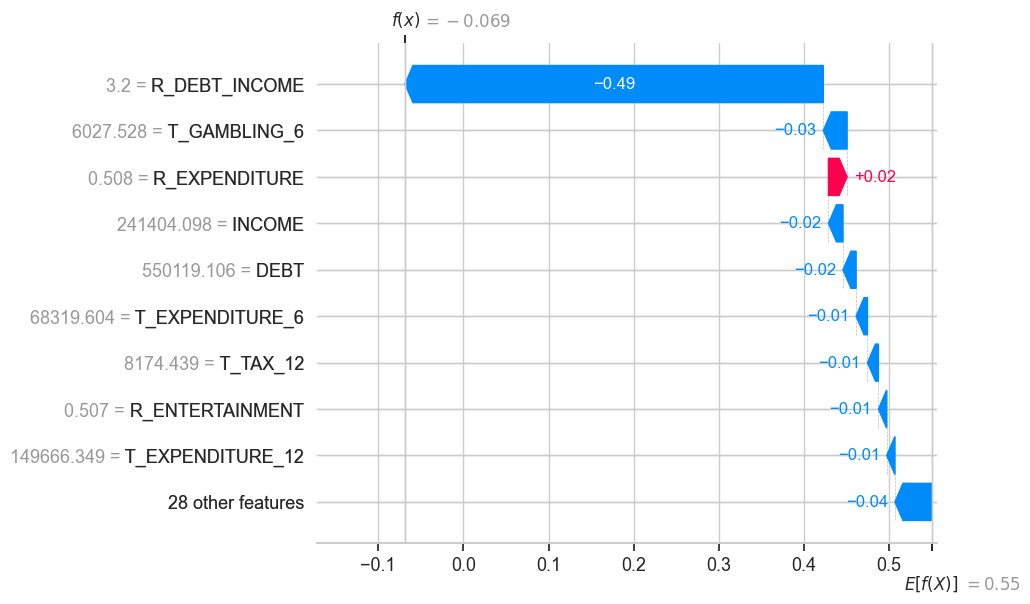

In [102]:
shap.plots.waterfall(shap_values[1])

In [103]:
shap.plots.force(shap_values[0:167])

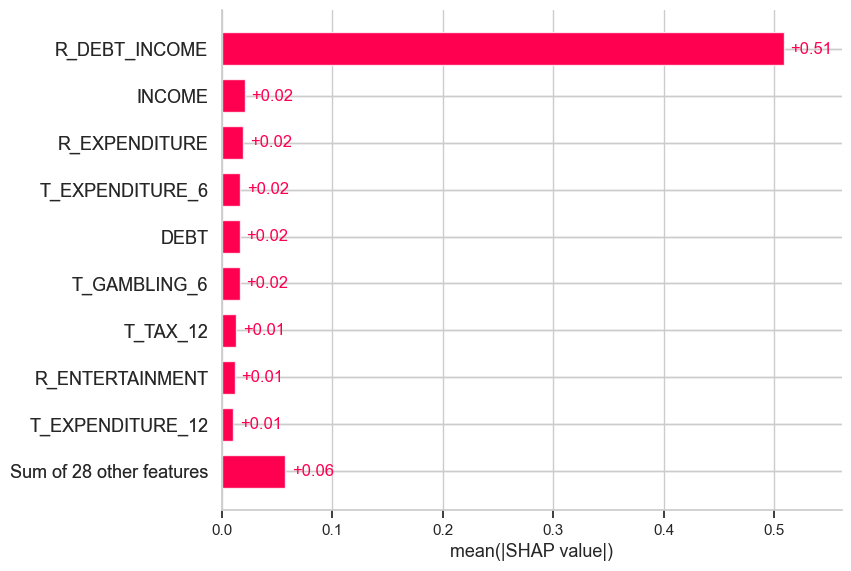

In [107]:
shap.plots.bar(shap_values)

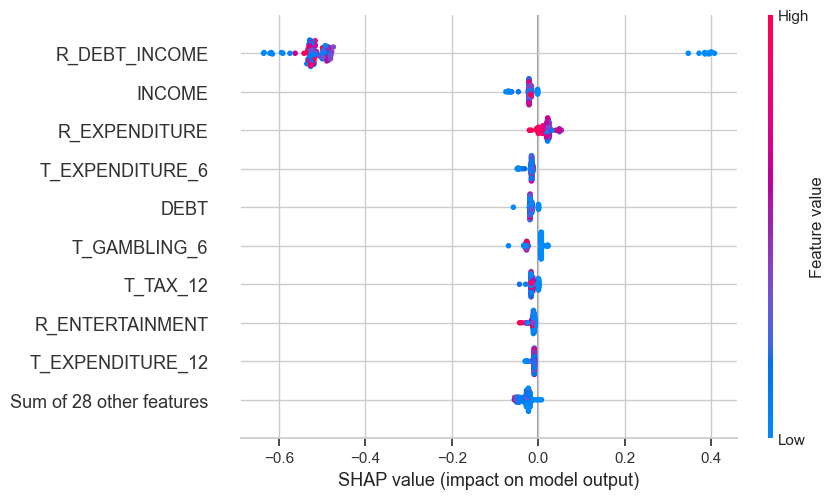

In [105]:
shap.plots.beeswarm(shap_values)

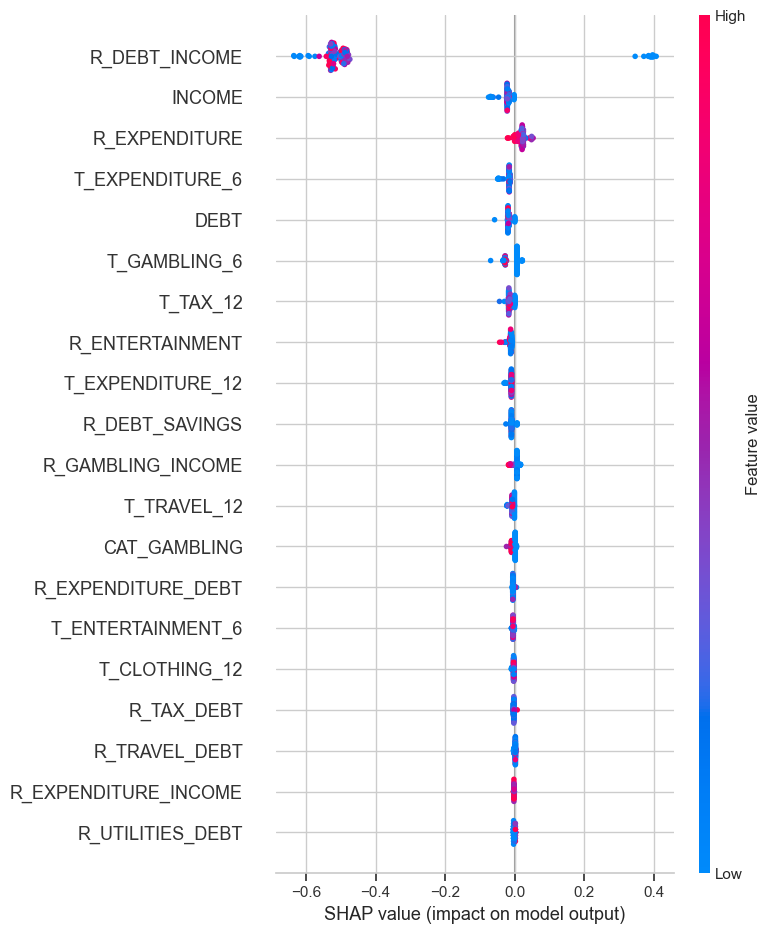

In [106]:


shap.summary_plot(shap_values, X_valid)



# Positive SHAP Values: When a feature has a positive SHAP value for certain observations, 
#     it means that in those cases, the feature's value has contributed to increasing the predicted credit score.
#     For example, a high income might generally be associated with a higher credit score, reflecting a borrower's ability to repay debts.

# Negative SHAP Values: Conversely, a negative SHAP value for the feature in other observations 
#     indicates that it has contributed to lowering the predicted credit score. An example might be 
#     the use of the same income feature but at a lower value, suggesting a lower capacity for debt repayment and therefore a lower credit score.

In [44]:
# Calculate prediction explanations for a single instance
instance_index = 0
instance_explanation = explainer.shap_values(X_valid.iloc[instance_index])

# Print prediction explanation for the instance
print("Prediction Explanation for Instance", instance_index)
print(instance_explanation)


Prediction Explanation for Instance 0
[-1.28404429e-02  9.46127960e-04 -8.40298456e-04  1.64178784e-04
 -4.98073128e-03 -5.08532191e-03  1.00023798e-03 -7.27910456e-03
 -5.38967496e-04  5.63654380e-04 -2.00755090e-01  9.15019918e-04
 -5.10119608e-04 -3.01170129e-03  6.74735922e-04  1.31767800e-04
 -1.25848411e-02 -1.86310629e-03  1.40827018e-03  6.57185109e-04
 -1.55680326e-03  9.58378175e-04 -5.79652032e-02 -9.13629225e-04
 -2.75707083e-03 -3.22989175e-03 -1.21909063e-03 -1.05909982e-03
 -1.67285695e-03 -2.47371837e-05 -2.46484716e-03  8.01722130e-03
  2.68585059e-03  7.22014713e-06 -6.52707286e-03 -1.51254499e-02
 -3.43839470e-03]


In [12]:
# last Spo predcition scores
# {'learning_rate': 0.6033700598512344,
#  'depth': 4,
#  'l2_leaf_reg': 38.92268508672135,
#  'min_child_samples': 123,
#  'iterations': 497}

In [24]:
print("Training set metrics:")
print(mean_squared_error(y_train, pred_train))
print(r2_score(y_train, pred_train))
print(mean_absolute_error(y_train, pred_train))
print(np.sqrt(mean_squared_error(y_train, pred_train)))

print("Validation set metrics:")
print(mean_squared_error(y_valid, pred_valid))
print(r2_score(y_valid, pred_valid))
print(mean_absolute_error(y_valid, pred_valid))
print(np.sqrt(mean_squared_error(y_valid, pred_valid)))

Training set metrics:
0.0005816144792516896
0.9662326694802698
0.017771913663655194
0.02411668466542799
Validation set metrics:
0.0035637785301644498
0.7876618291351005
0.04222805330608672
0.05969739131791648


In [13]:
# print("Training set metrics:")
# print(mean_squared_error(y_train, pred_train))
# print(r2_score(y_train, pred_train))
# print(mean_absolute_error(y_train, pred_train))
# print(np.sqrt(mean_squared_error(y_train, pred_train)))

# print("Validation set metrics:")
# print(mean_squared_error(y_valid, pred_valid))
# print(r2_score(y_valid, pred_valid))
# print(mean_absolute_error(y_valid, pred_valid))
# print(np.sqrt(mean_squared_error(y_valid, pred_valid)))


Training set metrics:
0.0020861356718066227
0.8788832890998062
0.03443580505288086
0.04567423422244343
Validation set metrics:
0.0035043265612778513
0.7912041150041146
0.041729216269541645
0.05919735265430247


In [25]:
from preprocessing.minmax_scaler import MinMaxScaling

predicted = MinMaxScaling().inverse_transform(pred_valid)
actual = MinMaxScaling().inverse_transform(y_valid)
print(mean_squared_error(actual, predicted))
print(r2_score(actual, predicted))
print(mean_absolute_error(actual, predicted))
print(np.sqrt(mean_squared_error(actual, predicted)))

757.3777770090791
0.7876618291351005
19.46713257410598
27.5204973975595


In [26]:
# Training set metrics:
# 0.0010818507548037424
# 0.9314771548203596
# 0.024995828691825792
# 0.03289149973479079
# Validation set metrics:
# 0.003781104669540127
# 0.7910454968147861
# 0.04361746360243078
# 0.061490687665207704

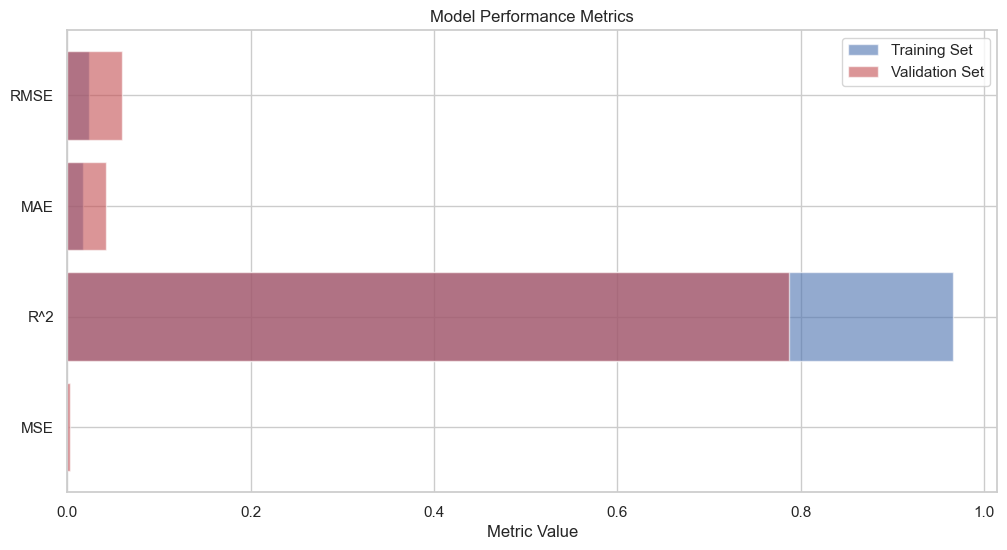

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define a function to plot the metrics
def plot_metrics(y_true_train, y_pred_train, y_true_valid, y_pred_valid):
    # Metrics calculation
    mse_train = mean_squared_error(y_true_train, y_pred_train)
    r2_train = r2_score(y_true_train, y_pred_train)
    mae_train = mean_absolute_error(y_true_train, y_pred_train)
    rmse_train = np.sqrt(mse_train)

    mse_valid = mean_squared_error(y_true_valid, y_pred_valid)
    r2_valid = r2_score(y_true_valid, y_pred_valid)
    mae_valid = mean_absolute_error(y_true_valid, y_pred_valid)
    rmse_valid = np.sqrt(mse_valid)

    # Plotting
    metrics = ['MSE', 'R^2', 'MAE', 'RMSE']
    train_values = [mse_train, r2_train, mae_train, rmse_train]
    valid_values = [mse_valid, r2_valid, mae_valid, rmse_valid]

    plt.figure(figsize=(12, 6))
    sns.set(style="whitegrid")
    plt.barh(metrics, train_values, color='b', alpha=0.6, label='Training Set')
    plt.barh(metrics, valid_values, color='r', alpha=0.6, label='Validation Set')

    plt.xlabel('Metric Value')
    plt.title('Model Performance Metrics')
    plt.legend()
    plt.show()

# Call the function with your prediction results
plot_metrics(y_train, pred_train, y_valid, pred_valid)


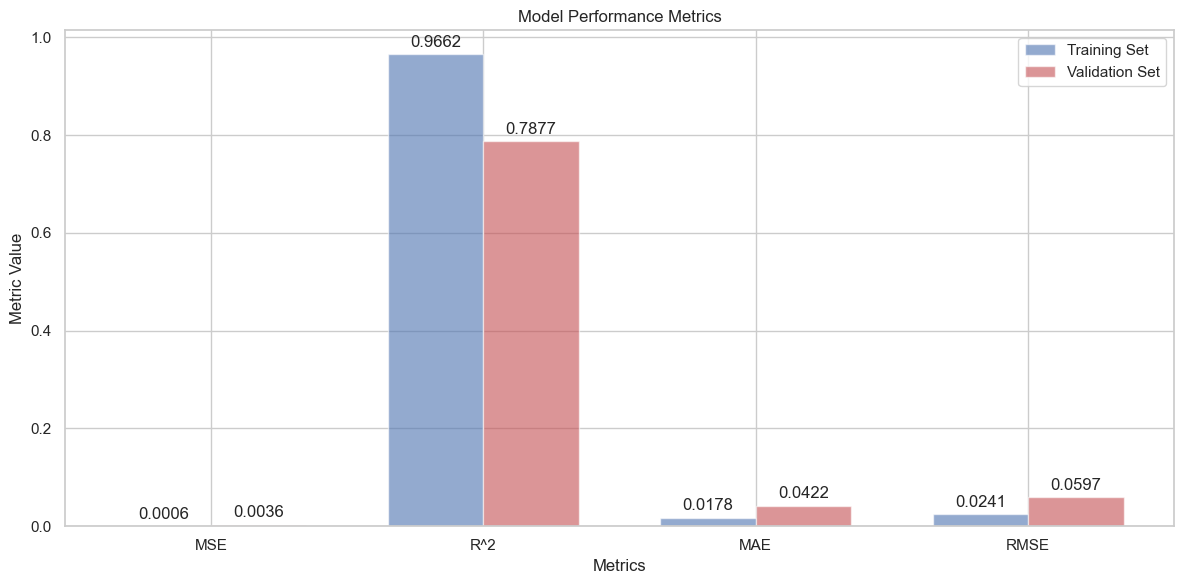

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Define a function to plot the metrics
def plot_metrics(y_true_train, y_pred_train, y_true_valid, y_pred_valid):
    # Metrics calculation
    mse_train = mean_squared_error(y_true_train, y_pred_train)
    r2_train = r2_score(y_true_train, y_pred_train)
    mae_train = mean_absolute_error(y_true_train, y_pred_train)
    rmse_train = np.sqrt(mse_train)

    mse_valid = mean_squared_error(y_true_valid, y_pred_valid)
    r2_valid = r2_score(y_true_valid, y_pred_valid)
    mae_valid = mean_absolute_error(y_true_valid, y_pred_valid)
    rmse_valid = np.sqrt(mse_valid)

    # Prepare data for plotting
    metrics = ['MSE', 'R^2', 'MAE', 'RMSE']
    train_values = [mse_train, r2_train, mae_train, rmse_train]
    valid_values = [mse_valid, r2_valid, mae_valid, rmse_valid]
    x = np.arange(len(metrics))  # the label locations
    width = 0.35  # the width of the bars

    # Plotting
    fig, ax = plt.subplots(figsize=(12, 6))
    rects1 = ax.bar(x - width/2, train_values, width, label='Training Set', color='b', alpha=0.6)
    rects2 = ax.bar(x + width/2, valid_values, width, label='Validation Set', color='r', alpha=0.6)

    # Add labels, title, and legend
    ax.set_xlabel('Metrics')
    ax.set_ylabel('Metric Value')
    ax.set_title('Model Performance Metrics')
    ax.set_xticks(x)
    ax.set_xticklabels(metrics)
    ax.legend()

    # Attach a text label above each bar in rects, displaying its height
    def autolabel(rects):
        for rect in rects:
            height = rect.get_height()
            ax.annotate('{:.4f}'.format(height),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')
    autolabel(rects1)
    autolabel(rects2)

    fig.tight_layout()

    plt.show()

# Call the function with your prediction results
plot_metrics(y_train, pred_train, y_valid, pred_valid)


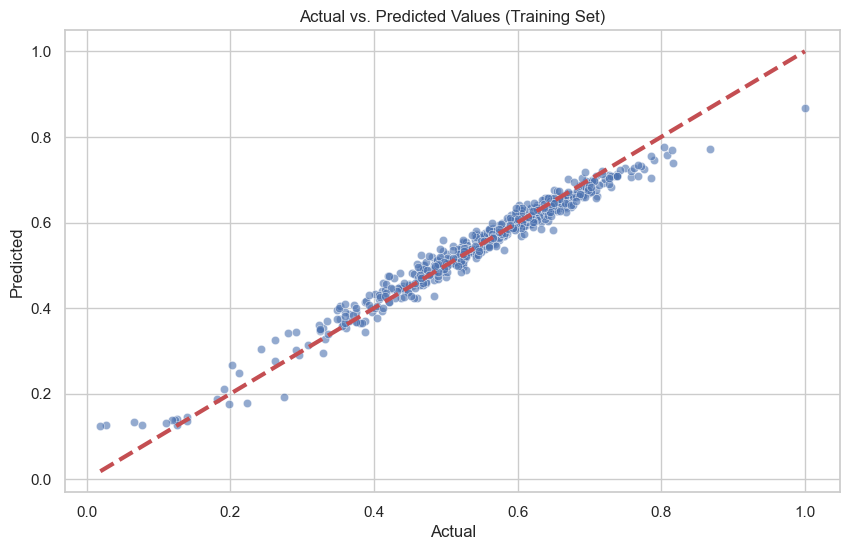

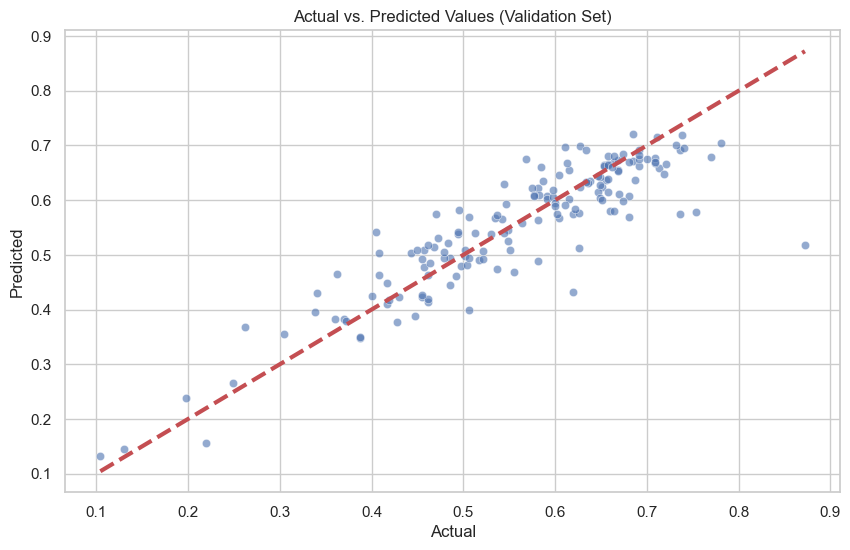

In [28]:
def plot_actual_vs_predicted(y_true, y_pred, dataset_type='Training'):
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=y_true, y=y_pred, alpha=0.6)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=3) # Diagonal line
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title(f'Actual vs. Predicted Values ({dataset_type} Set)')
    plt.show()

plot_actual_vs_predicted(y_train, pred_train, 'Training')
plot_actual_vs_predicted(y_valid, pred_valid, 'Validation')


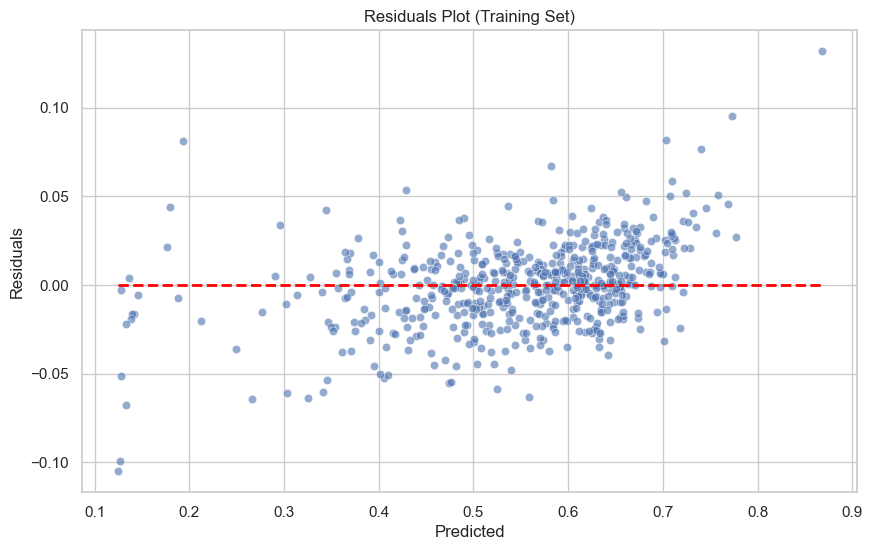

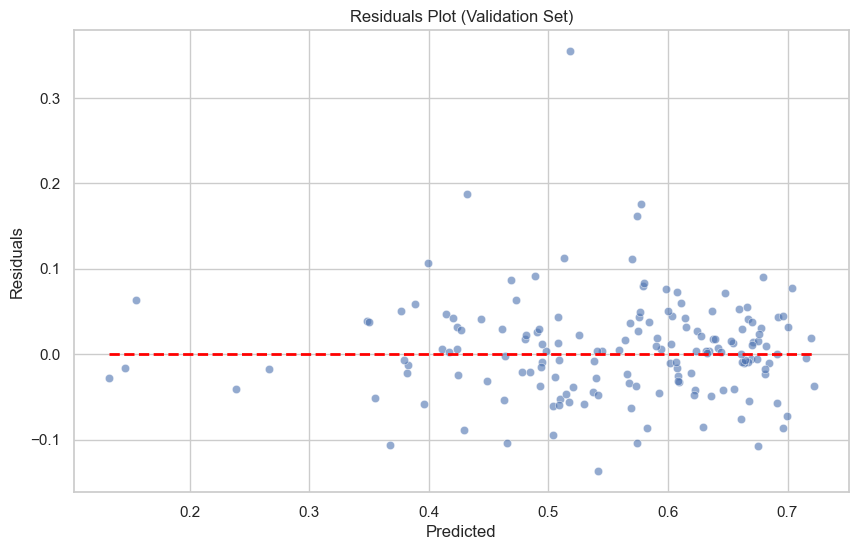

In [29]:
def plot_residuals(y_true, y_pred, dataset_type='Training'):
    residuals = y_true - y_pred
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=y_pred, y=residuals, alpha=0.6)
    plt.hlines(y=0, xmin=y_pred.min(), xmax=y_pred.max(), colors='red', linestyles='--', lw=2)
    plt.xlabel('Predicted')
    plt.ylabel('Residuals')
    plt.title(f'Residuals Plot ({dataset_type} Set)')
    plt.show()

plot_residuals(y_train, pred_train, 'Training')
plot_residuals(y_valid, pred_valid, 'Validation')


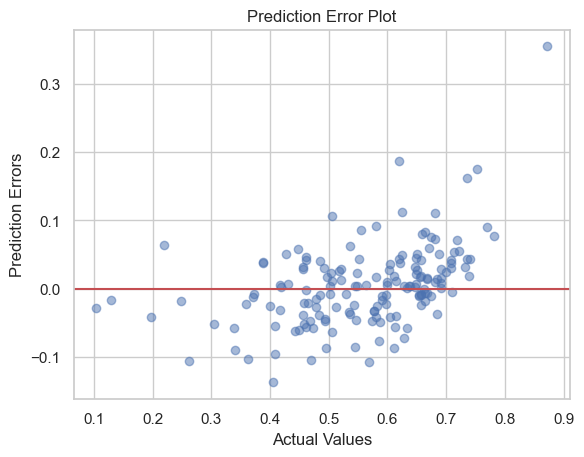

In [58]:
import matplotlib.pyplot as plt

# Calculate prediction errors
errors = y_valid - pred_valid

# Plot prediction errors
plt.scatter(y_valid, errors, alpha=0.5)
plt.xlabel('Actual Values')
plt.ylabel('Prediction Errors')
plt.title('Prediction Error Plot')
plt.axhline(y=0, color='r', linestyle='-')
plt.show()
